# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.

# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PowerTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()

# Display first few rows and basic statistics
display(fires_dt.head())
display(fires_dt.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


,coord_x,coord_y,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


# Get X and Y

Create the features data frame and target data.

In [3]:
# Separate features and target
X = fires_dt.drop(columns='area')
y = fires_dt['area']

# Split the data with 80-20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (413, 12)
Test set shape: (104, 12)


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [4]:
# Column categorization
numeric_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_features = ['month', 'day']

In [5]:
# Preprocessor 1: Scaling and encoding
preproc1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    verbose_feature_names_out=False
)
preproc1

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])],
                  verbose_feature_names_out=False)

### Preproc 2

Create preproc2 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [6]:
# Display skewness analysis
numeric_skewness = X_train[numeric_features].skew().sort_values(ascending=False)
print("Skewness of numeric features:")
display(numeric_skewness)

Skewness of numeric features:


rain       19.112564
rh          0.850107
isi         0.587755
dmc         0.582128
wind        0.567032
coord_y     0.487873
coord_x     0.067740
temp       -0.272311
dc         -1.097032
ffmc       -6.473877
dtype: float64

In [7]:
# Create custom transformer class (because lambda functions are not picklable)
def log_transform_func(x):
    """
    Apply log1p transformation to positive values, return 0 for non-positive values
    """
    return np.where(x > 0, np.log1p(x), 0)

class LogTransformer(FunctionTransformer):
    def __init__(self):
        super().__init__(
            func=log_transform_func,
            validate=False,
            feature_names_out='one-to-one'
        )

# Create preproc2 with simplified transformations
preproc2 = ColumnTransformer(
    transformers=[
        # Basic scaling for most numeric features
        ('num_standard', StandardScaler(), 
         ['coord_x', 'coord_y', 'temp', 'dc']),
        
        # Power transformation for moderately skewed features
        ('num_power', Pipeline([
            ('power', PowerTransformer(method='yeo-johnson')),
            ('scale', StandardScaler())
        ]), ['dmc', 'isi', 'rh', 'wind']),
        
        # Special handling for rain (keeping zeros as zeros)
        ('num_rain', Pipeline([
            ('transform', LogTransformer()),
            ('scale', StandardScaler())
        ]), ['rain']),
        
        # Special handling for ffmc
        ('num_ffmc', RobustScaler(), ['ffmc']),
        
        # Categorical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    verbose_feature_names_out=False
)

preproc2

ColumnTransformer(transformers=[('num_standard', StandardScaler(),
                                 ['coord_x', 'coord_y', 'temp', 'dc']),
                                ('num_power',
                                 Pipeline(steps=[('power', PowerTransformer()),
                                                 ('scale', StandardScaler())]),
                                 ['dmc', 'isi', 'rh', 'wind']),
                                ('num_rain',
                                 Pipeline(steps=[('transform',
                                                  LogTransformer()),
                                                 ('scale', StandardScaler())]),
                                 ['rain']),
                                ('num_ffmc', RobustScaler(), ['ffmc']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])],
                  verbose_feature_names_out=False)

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [8]:
# Pipeline A = preproc1 + baseline
pipeline_a = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', LinearRegression())
])

pipeline_a

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])],
                                   verbose_feature_names_out=False)),
                ('regressor', LinearRegression())])

In [9]:
# Pipeline B = preproc2 + baseline
pipeline_b = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', LinearRegression())
])

pipeline_b

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_standard',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'temp',
                                                   'dc']),
                                                 ('num_power',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['dmc', 'isi', 'rh', 'wind']),
                                                 ('num_rain',
                                                  Pipeline(steps=[('transform',
                                                                   LogTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['rain']),
                                                 ('num_ffmc', RobustScaler(),
                                                  ['ffmc']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])],
                                   verbose_feature_names_out=False)),
                ('regressor', LinearRegression())])

In [10]:
# Pipeline C = preproc1 + advanced model
pipeline_c = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor(random_state=42))
])

pipeline_c

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])],
                                   verbose_feature_names_out=False)),
                ('regressor', RandomForestRegressor(random_state=42))])

In [11]:
# Pipeline D = preproc2 + advanced model
pipeline_d = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor(random_state=42))
])

pipeline_d

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_standard',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'temp',
                                                   'dc']),
                                                 ('num_power',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['dmc', 'isi', 'rh', 'wind']),
                                                 ('num_rain',
                                                  Pipeline(steps=[('transform',
                                                                   LogTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['rain']),
                                                 ('num_ffmc', RobustScaler(),
                                                  ['ffmc']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])],
                                   verbose_feature_names_out=False)),
                ('regressor', RandomForestRegressor(random_state=42))])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [12]:
# Define parameter grids - expanded to include more cases
param_grid_a = {
    'regressor__fit_intercept': [True, False],
    'regressor__positive': [True, False]
}

param_grid_b = {
    'regressor__fit_intercept': [True, False],
    'regressor__positive': [True, False]
}

param_grid_c = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20]
}

param_grid_d = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20]
}

In [13]:
# Perform GridSearch with 5-fold CV (34s)
results = {}
pipelines = [pipeline_a, pipeline_b, pipeline_c, pipeline_d]
param_grids = [param_grid_a, param_grid_b, param_grid_c, param_grid_d]
pipeline_names = ['Pipeline_A', 'Pipeline_B', 'Pipeline_C', 'Pipeline_D']

for pipeline, param_grid, name in zip(pipelines, param_grids, pipeline_names):
    print(f"\nTraining {name}...")
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',  # Using RMSE as error metric
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': -grid_search.best_score_,
        'test_rmse': np.sqrt(mean_squared_error(
            y_test, 
            grid_search.predict(X_test)
        )),
        'test_mae': mean_absolute_error(
            y_test, 
            grid_search.predict(X_test)
        ),
        'test_score': grid_search.best_estimator_.score(X_test, y_test),
        'model': grid_search.best_estimator_
    }


Training Pipeline_A...

Training Pipeline_B...

Training Pipeline_C...

Training Pipeline_D...


In [14]:
# Create performance comparison dataframe
performance_df = pd.DataFrame({
    'Pipeline': list(results.keys()),
    'Best Score': [results[p]['best_score'] for p in results.keys()], 
    'Test RMSE': [results[p]['test_rmse'] for p in results.keys()],
    'Test MAE': [results[p]['test_mae'] for p in results.keys()],
    'Test Score': [results[p]['test_score'] for p in results.keys()],
})

print("Model Performance Comparison:")
display(performance_df)


Model Performance Comparison:


,Pipeline,Best Score,Test RMSE,Test MAE,Test Score
0,Pipeline_A,40.161867,108.303728,24.681970,0.004926
1,Pipeline_B,40.113889,108.253563,24.765862,0.005847
2,Pipeline_C,48.187528,109.665566,26.970423,-0.020256
3,Pipeline_D,48.790446,110.017020,26.894040,-0.026806


# Evaluate

+ Which model has the best performance?

In [15]:
# Find best model based on RMSE
best_pipeline = min(results.items(), key=lambda x: x[1]['test_rmse'])[0]
print(f"\nBest performing pipeline: {best_pipeline}")
print(f"Best parameters: {results[best_pipeline]['best_params']}")


Best performing pipeline: Pipeline_B
Best parameters: {'regressor__fit_intercept': False, 'regressor__positive': True}


# Export

+ Save the best performing model to a pickle file.

In [16]:
# Save the best model using context manager
best_model_filename = 'best_model.pkl'
best_model = results[best_pipeline]['model']
with open(best_model_filename, 'wb') as f:
    pickle.dump(best_model, f)

print(f"Best model saved as '{best_model_filename}'")

Best model saved as 'best_model.pkl'


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [17]:
# SHAP Analysis

best_model.fit(X_train, y_train)

# Get transformed data
X_test_transformed = best_model.named_steps['preprocessing'].transform(X_test)

# Get feature names from the preprocessing step only (excluding the regressor)
feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()

print("Shape of transformed data:", X_test_transformed.shape)
print("Number of features:", len(feature_names))

if isinstance(best_model.named_steps['regressor'], RandomForestRegressor):
    # Tree-based model SHAP analysis
    explainer = shap.TreeExplainer(best_model.named_steps['regressor'])
else:
    # Linear model SHAP analysis
    explainer = shap.explainers.Linear(
        best_model.named_steps['regressor'],
        X_test_transformed,
        feature_names=feature_names
    )
        
explanation = explainer(X_test_transformed)

chosen_observation_loc = X_test_transformed.shape[0] - 1 # last observation

chosen_observation_original_df = X_test.iloc[[chosen_observation_loc]]
chosen_observation_transformed_df = pd.DataFrame([X_test_transformed[chosen_observation_loc]], columns=feature_names)

display(chosen_observation_original_df)
display(chosen_observation_transformed_df)

Shape of transformed data: (104, 29)
Number of features: 29


,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain
320,6,3,sep,thu,92.8,119.0,783.5,7.5,18.9,34,7.2,0.0


,coord_x,coord_y,temp,dc,dmc,isi,rh,wind,rain,ffmc,...,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,0.584341,-1.094859,0.002219,0.938831,0.221007,-0.256939,-0.557083,1.61799,-0.087898,0.444444,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


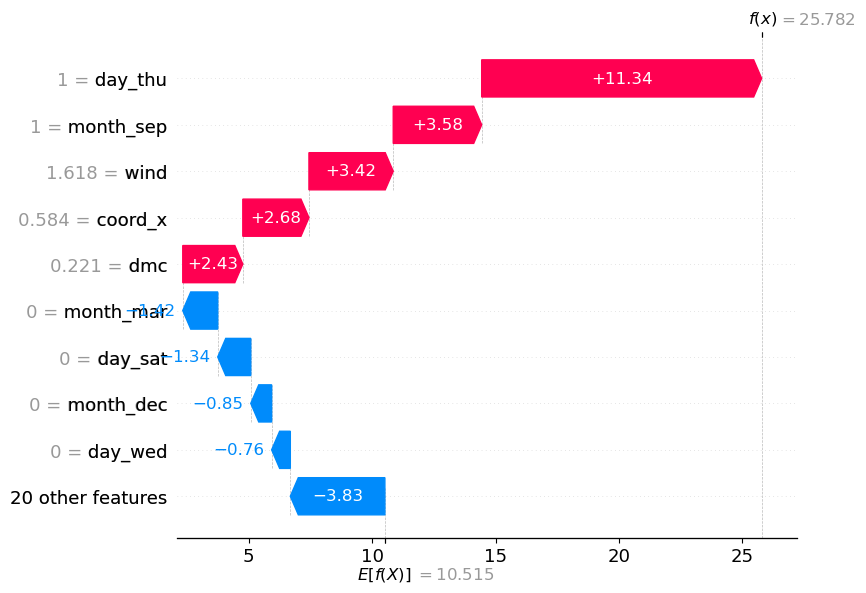

In [18]:
chosen_observation_shape_values = explanation[chosen_observation_loc]
#display(chosen_observation_shape_values)
shap.plots.waterfall(chosen_observation_shape_values)

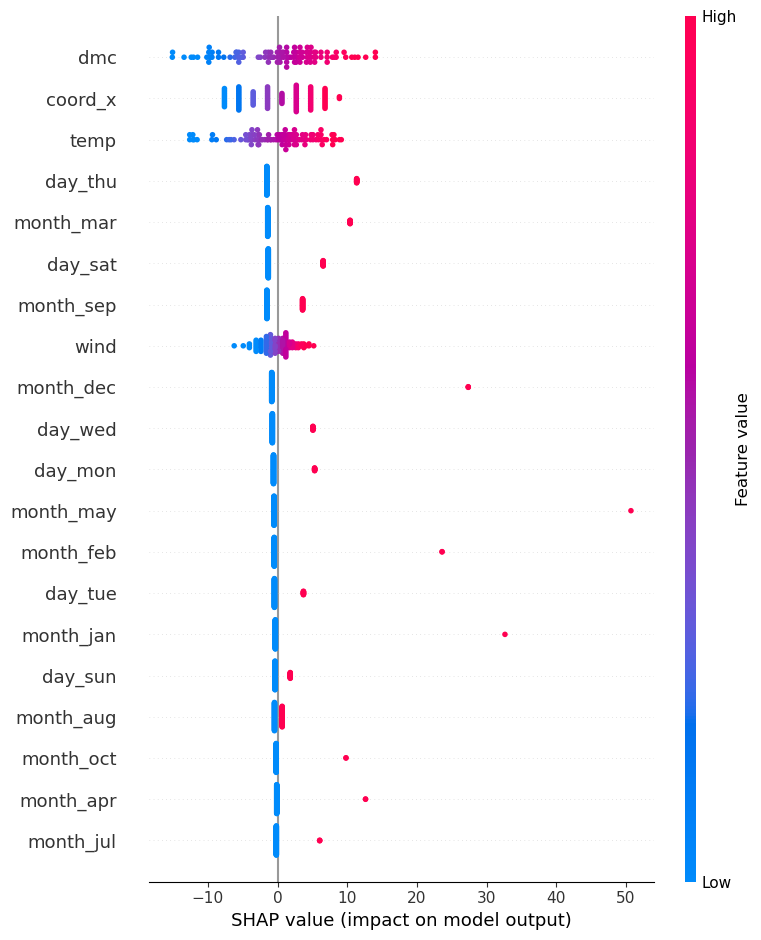

In [19]:
shap.summary_plot(explanation, features=X_test_transformed, feature_names=feature_names)

*(Answer here.)*

### Feature Importance for a Selected Observation
Looking at the SHAP (SHapley Additive exPlanations) Waterfall diagram for a specific prediction, we can say the model predicted a value of f(x) = 25.782 for that observation, with a base expected value E[f(X)] = 10.515.

#### Features with Positive Impact
1. `day_thu` (+11.34): Being a Thursday had the largest positive impact, increasing the prediction by 11.34 units
1. `month_sep` (+3.58): September contributed the second-largest positive impact
1. `wind` (3.42): A wind value of 1.618 had a substantial positive effect
1. `coord_x` (+2.68): The coordinate value of 0.584 positively influenced the prediction
1. `dmc` (+2.43): A DMC value of 0.221 also added positively to the prediction

#### Features with Negative Impact
1. `month_mar` (-1.42): March had a moderate negative impact
1. `day_sat` (-1.34): Saturday decreased the prediction
1. `month_dec` (-0.85): December had a small negative effect
1. `day_wed` (-0.76): Wednesday slightly decreased the prediction
1. "20 other features" collectively had a negative impact of -3.83

#### Key Insights
The temporal features (day and month) had the strongest individual impacts
Environmental factors (wind, coord_x, dmc) had moderate but consistent positive impacts
The final prediction (25.782) is significantly higher than the base expectation (10.515), mainly driven by it being a Thursday in September with specific environmental conditions
While there are 20 other features, their combined impact (-3.83) is less than the single impact of the most important feature (day_thu at +11.34)

This suggests that for this specific observation, the temporal aspects, particularly the day of the week (Thursday) and month (September), were the primary drivers of the high prediction value, supported by favorable environmental conditions (wind, coordinates, and DMC measurements).

### Feature Importance accross the Complete Training Set
From the SHAP Beewax plot of feature importance, the following insights can be derived:

#### Most Important Features
1. `dmc`, `coord_x`, and `temp` show the widest spread of SHAP values and most dense distribution of points, indicating they have the strongest impact on model predictions
1. These features have both positive and negative impacts, suggesting they can significantly push predictions in either direction

#### Least Important Features
1. Month variables (`jul`, `apr`, `oct`, `aug`) and some day variables (`sun`, `tue`) show very minimal spread and fewer points
1. These features have relatively small SHAP values (closer to 0), indicating minimal impact on model predictions

#### Feature Removal Candidates
I would consider removing:
1. Lower-impact month variables (jul, apr, oct, aug)
1. Lower-impact day variables (sun, tue)
1. Potentially consolidate individual month/day variables into more meaningful temporal features

#### Rationale
1. These features show minimal SHAP values
1. Having too many temporal features might be redundant
1. Simpler models are generally preferred if they can achieve similar performance

#### Testing Feature Importance
To validate whether removing these features actually improves (or doesn't harm) model performance, I would validate the feature removal impact through a systematic evaluation process:

1. Establish Baseline
- First record the original model's performance metrics on both training and test sets
- Document key metrics like RMSE, MAE, and R-squared for regression, or accuracy/F1 for classification
2. Feature Removal and Retraining
- Remove the identified low-importance features
- Retrain the model using identical hyperparameters on the reduced feature set
- Evaluate the new model on the same test set to ensure fair comparison
3. Cross-Validation Analysis
- Implement k-fold cross-validation (e.g., k=5 or k=10) on both versions
- Compare not just mean performance but also variance across folds
- Test for statistical significance in performance differences
- Look for any signs of altered bias-variance tradeoff

This rigorous approach ensures that any improvements or degradations in model performance are genuine and not due to random variation in the data splits.


## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ x ] Created a branch with the correct naming convention.
- [ x ] Ensured that the repository is public.
- [ x ] Reviewed the PR description guidelines and adhered to them.
- [ x ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.